# Feature selection and extraction

In [1]:
# Loading basic libraries
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reading Cancer Data
cancer = datasets.load_breast_cancer()
X,y = cancer.data,cancer.target
X_df = pd.DataFrame(X, columns= cancer.feature_names)

# Remove low variance features

In [3]:
# Removing Feature which has very low variance
# before finding variance data should be normalized , Every feature will be comparable then
print("Shape before Variance dimension reduction :" , X_df.shape)

from sklearn.feature_selection import VarianceThreshold
normal_df = X_df/X_df.mean()
sel = VarianceThreshold(threshold=0.05)
sel.fit(normal_df)

# create boolean mask
mask = sel.get_support()
X_df = X_df.loc[:,mask]

print("Shape After Variance dimension reduction :" , X_df.shape)


Shape before Variance dimension reduction : (569, 30)
Shape After Variance dimension reduction : (569, 23)


# High percentage of Null values

In [4]:
# Create a boolean mask on whether each feature less than 50% missing values.
print("Shape Before Null dimension reduction :" , X_df.shape)

mask = X_df.isna().sum() / len(X_df) < 0.5
X_df = X_df.loc[:,mask]

print("Shape After Null dimension reduction :" , X_df.shape)

Shape Before Null dimension reduction : (569, 23)
Shape After Null dimension reduction : (569, 23)


# Highly Co-related features

Before corelation dimension reduction : (569, 23)


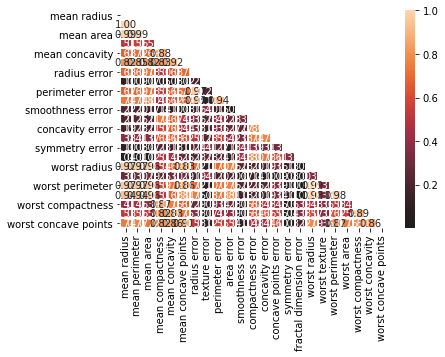

After corelation dimension reduction : (569, 17)


In [5]:
# Calculate the correlation matrix and take the absolute value
print("Before corelation dimension reduction :" , X_df.shape)

corr_matrix = X_df.corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Creating mask for removing uper triangle of corelation matrix
sns.heatmap(corr_matrix , mask=mask, center=0, linewidths=1, annot=True, fmt=".2f")
plt.show()

tri_df = corr_matrix.mask(mask) # creating dataframe of corelated values
# List column names of highly correlated features (r > 0.95)
to_drop = [c for c in tri_df.columns if any(tri_df[c] >  0.95)]
X_df = X_df.drop(to_drop, axis=1)

print("After corelation dimension reduction :" , X_df.shape)

# Recursive feature eliminations ( RFE)

In [6]:
# Which ever model capable of generating coefficients for variables OR features importance acn be worked RFE
# Create the RFE with a LogisticRegression estimator and 3 features to select
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df, y,test_size=0.3,random_state= 100)

In [7]:
# Creating RFE Object for Logistic Regressor and Random forest model
# 10 Features selected by both model
rfe_logistic = RFE(estimator=LogisticRegression(), n_features_to_select=10, verbose=1)
rfe_forest = RFE(estimator=RandomForestClassifier(), n_features_to_select=10, verbose=1)

# Fits the eliminator to the data
rfe_logistic.fit(X_train, y_train)
rfe_forest.fit(X_train, y_train)

# features and their ranking (high = dropped early on)
dict(zip(X_df.columns, rfe_logistic.ranking_))
dict(zip(X_df.columns, rfe_forest.ranking_))

# Print the features that are not eliminated
logistic_features= X_df.columns[rfe_logistic.support_]
forest_features= X_df.columns[rfe_forest.support_]

# Different variables selected by models
diff = set(logistic_features) - set(forest_features)
print("feature difference - ",diff)

Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
feature difference -  {'texture error', 'mean compactness', 'concavity error'}


In [8]:
# Calculates the test set accuracy
from sklearn.metrics import  accuracy_score
acc_logistic = accuracy_score(y_test, rfe_logistic.predict(X_test))
acc_forest = accuracy_score(y_test, rfe_forest.predict(X_test))
print("{0:.2%} logistic model accuracy on test set.".format(acc_logistic))
print("{0:.2%} Random forest model accuracy on test set.".format(acc_forest))

93.57% logistic model accuracy on test set.
94.74% Random forest model accuracy on test set.


# Principal component Analysis (PCA)

In [9]:
# Feature extraction model
# Standardisation of numerical data is very important
# Desn't work good on categorical data
# Based on variance explained by components
# Components created by PCA are non-corelated

In [10]:
# Standaridizing data ( Mean = 0 and variance = 1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X_df) # Fit and transform

# Cretating PCA object
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_std) # only fit here to see various characters
var = pca.explained_variance_ratio_ # Various components explaining variance of the data
print("Commulative variance % :",var.cumsum().round(3)) # * components together explains 92.08 % variance

Commulative variance % : [0.491 0.658 0.762 0.836 0.875 0.909 0.933 0.952 0.966 0.979 0.986 0.992
 0.995 0.997 0.998 0.999 1.   ]


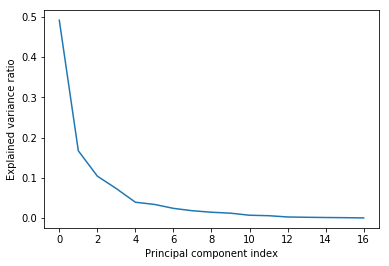

In [11]:
# Ploting and deciding how many components are relevent at % variance explained
# Elbow rule can be applied
# X asix is Index ( number of components = index + 1)
plt.plot(var)
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.show()

# Number of componets can be choosen by providing n_componets argument in PCA
## 1. % to select number of components which explain atleast % of variance (n_componets = 0.9)
## 2. number .. Absolute number as decided by above plot (n_componets = 2)


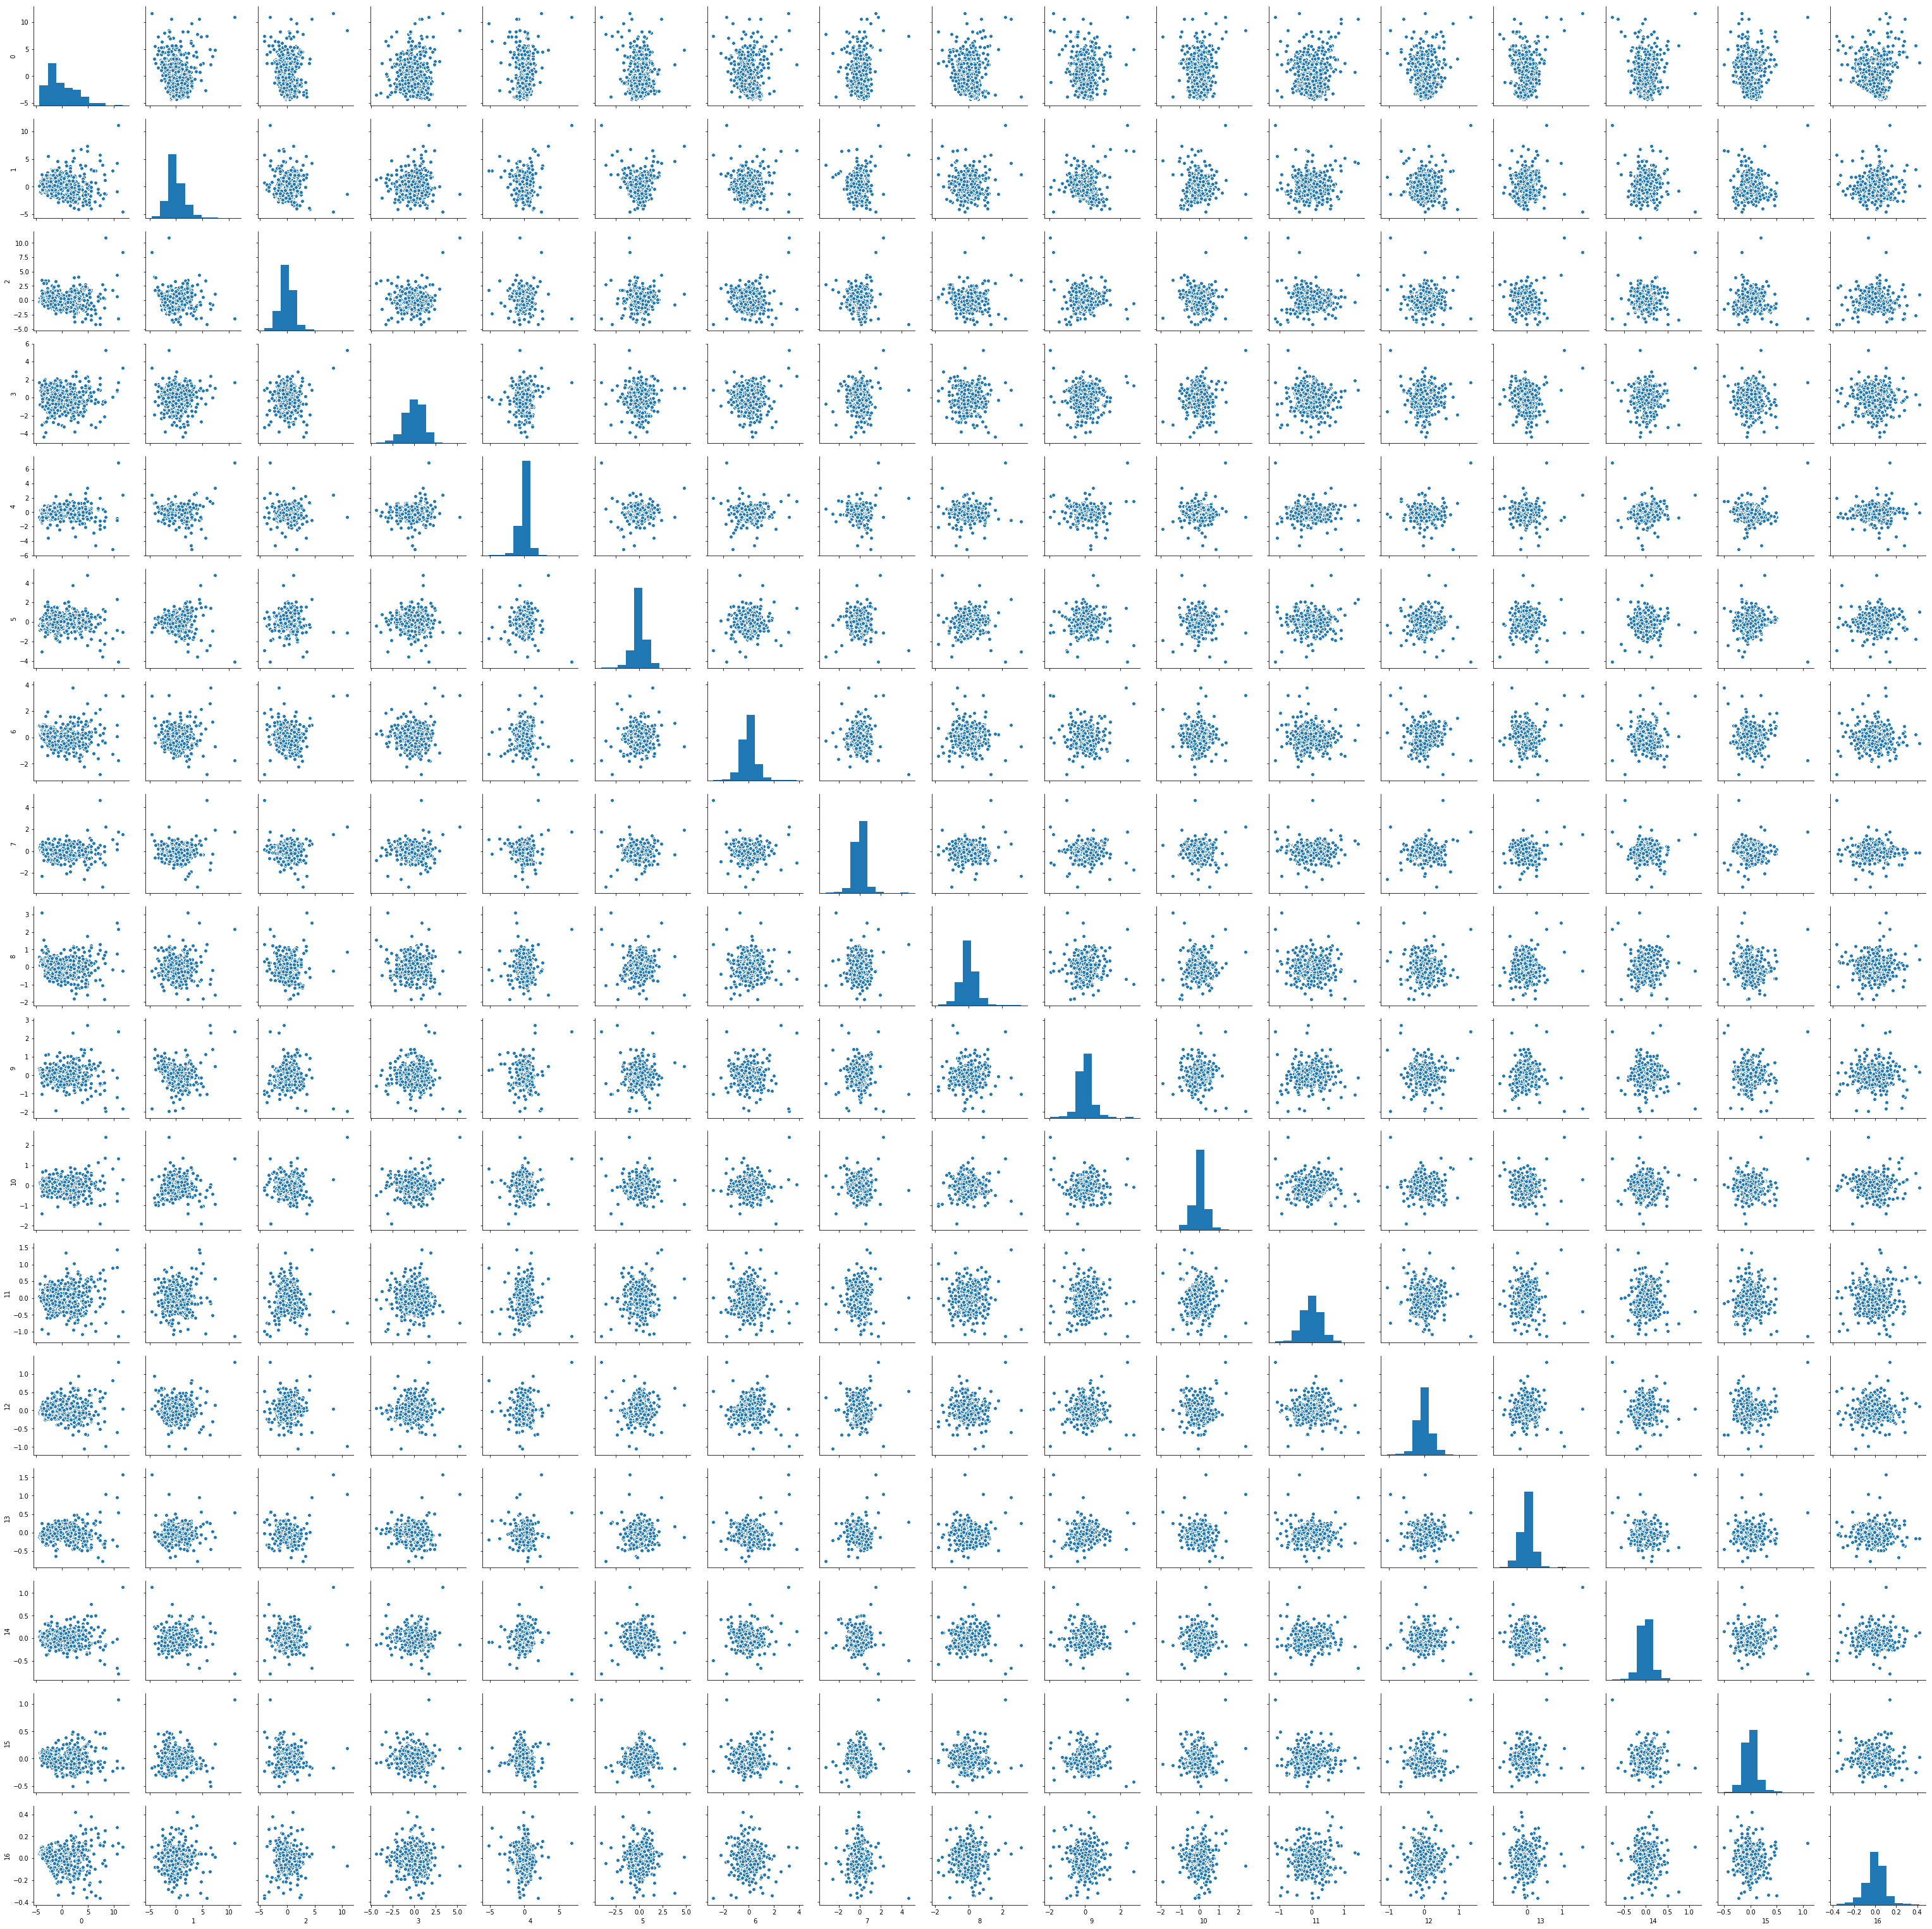

In [12]:
pc = pca.transform(X_std) # fit and transform can be done in one go by fit_transofrm
sns.pairplot(pd.DataFrame(pc))
plt.show()

# All created components are non-corelated

In [13]:
# Build the PCA pipeline and Model
from sklearn.pipeline import Pipeline
stage= [('scaler', StandardScaler()),
        ('reducer', PCA(n_components=0.95)),
        ('classifier', RandomForestClassifier(random_state=0))]

pipe = Pipeline(stage)

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Score the accuracy on the test set
accuracy = pipe.score(X_test, y_test)

# Prints the explained variance ratio and accuracy
print((pipe.steps[1][1].explained_variance_ratio_).round(3))
print('{0:.1%} test set accuracy'.format(accuracy))

[0.481 0.172 0.109 0.075 0.035 0.031 0.026 0.021]
92.4% test set accuracy


# Esemble feature selection models

In [14]:
# ensemble Feature selection
# LassoCV + Gradient booster + Random forest models used for finding appropriate features

boston = datasets.load_boston()
X,y = boston.data,boston.target
X_df = pd.DataFrame(X, columns= boston.feature_names)
X_train, X_test, y_train, y_test = train_test_split(X_df, y,test_size=0.3,random_state= 100)

In [15]:
# Feature selection from LASSO model
from sklearn.linear_model import LassoCV

# Create and fit the LassoCV model on the training set
lcv = LassoCV()
lcv.fit(X_train,y_train)

## LassoCV also do hyper parameter optimization for Alpha
print('Optimal alpha = {0:.3f}'.format(lcv.alpha_))

# Calculate R squared on the test set
r_squared = lcv.score(X_test,y_test)
print('R2 for LassoCV {0:.1%} '.format(r_squared))

# Create a mask for coefficients not equal to zero
lcv_mask = lcv.coef_ !=0
print('{} features out of {} selected'.format(sum(lcv_mask), len(lcv_mask)))

Optimal alpha = 0.720
R2 for LassoCV 66.0% 
10 features out of 13 selected


In [16]:
# Feature selection for gradient boosting Regressor model and Random forest model
# Select 10 features with RFE on a GradientBoostingRegressor, drop 3 features on each step
# n_features_to_select=10 got from LassoCV model

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

rfe_gb = RFE(estimator=GradientBoostingRegressor(),n_features_to_select=10, step=3, verbose=1)
rfe_rf = RFE(estimator=RandomForestRegressor(),n_features_to_select=10, step=3, verbose=1)

rfe_gb.fit(X_train, y_train)
rfe_rf.fit(X_train, y_train)

r_squared = rfe_gb.score(X_test,y_test)
print('R2 for Gradient boosting {0:.1%} '.format(r_squared))
r_squared = rfe_rf.score(X_test,y_test)
print('R2 for Random forest {0:.1%} '.format(r_squared))

Fitting estimator with 13 features.
Fitting estimator with 13 features.
R2 for Gradient boosting 83.1% 
R2 for Random forest 76.1% 


In [17]:
# creating mask for models support_ contains boolean record
gb_mask = rfe_gb.support_
rf_mask = rfe_rf.support_

# combined votes for features
votes = np.sum([lcv_mask,gb_mask,rf_mask],axis=0)
meta_mask = votes >= 2
X_reduced = X_df.loc[:,meta_mask]
print(X_reduced.columns)

Index(['CRIM', 'ZN', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B',
       'LSTAT'],
      dtype='object')


In [18]:
# Final model using Random forest.
# X_reduced variable dataFrame will be used for input
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y,test_size=0.3,random_state= 100)
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train,y_train)

r_squared = gb_model.score(X_test,y_test)
print('R2 for Final Gradient Boostin Model {0:.1%} '.format(r_squared))

R2 for Final Gradient Boostin Model 83.0% 
